<a href="https://colab.research.google.com/github/ch3ker/sentiment-analysis/blob/main/copy_of_DeepLearning_Medium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook Overview
This notebook demonstrates a question-answering (QA) pipeline using a pretrained transformer model on the BoolQ dataset. BoolQ (Boolean Questions) is a QA dataset focused on yes/no questions, which allows us to explore binary classification in QA contexts. We’ll use a pipeline model from Hugging Face's transformers library to answer these questions directly without fine-tuning, leveraging the pretrained capabilities of models like DistilBERT or similar lightweight alternatives.

#Process Outline
- Dataset Overview: We’ll explore the BoolQ dataset, its structure, and its unique properties that suit binary yes/no question answering.
- Pipeline Initialization: Set up a pre-trained QA pipeline model for binary-style answers.
- Question Answering on Sample Data: Run the QA pipeline on sample questions and contexts from the BoolQ dataset to generate yes/no answers with confidence scores.
- Results Analysis: Assess the pipeline’s performance by reviewing generated answers and confidence scores.

#Dataset Overview
- Dataset Name: BoolQ (Boolean Questions)

- Description:
BoolQ, developed by Google AI, is a QA dataset focused on binary (yes/no) questions that require reasoning over context passages. Unlike open-ended QA datasets, BoolQ provides structured yes/no answers, making it well-suited for tasks where binary classification is needed. It’s particularly useful for applications that involve validation or verification against provided information.

- Dataset Structure:

 - Splits: BoolQ has three primary splits: train, validation, and test.
 - Key Fields:
    - question: The yes/no question being asked.
    - passage: A context paragraph where the answer to the question can be found.
    - answer: The binary answer (either True for yes or False for no).

#Using the Model DistilBERT for binary classification

##Initial Setup

In [ ]:
!pip install transformers datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 18.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 18.0.0 which is incompatible.


In [ ]:
!pip install torch


In [ ]:
!pip install evaluate  # If not already installed



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.8 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset

In [ ]:
from evaluate import load
import numpy as np

##Loading Dataset

In [ ]:
# Load the BoolQ dataset and take a subset for quicker training
dataset = load_dataset("boolq")
small_train_dataset = dataset['train'].shuffle(seed=42).select(range(1000))  # 1000 samples for training
small_val_dataset = dataset['validation'].shuffle(seed=42).select(range(200))  # 200 samples for validation


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.69M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9427 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3270 [00:00<?, ? examples/s]

##Data Understanding

In [ ]:
print("Dataset structure:", dataset)

Dataset structure: DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'passage'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['question', 'answer', 'passage'],
        num_rows: 3270
    })
})


In [ ]:
print("Training samples:", len(dataset['train']))


Training samples: 9427


In [ ]:
print("Validation samples:", len(dataset['validation']))


Validation samples: 3270


In [ ]:
print("Available splits:", dataset.keys())


Available splits: dict_keys(['train', 'validation'])


In [ ]:
# View the first few samples in the training set
for sample in dataset['train'].select(range(3)):
    print("Question:", sample['question'])
    print("Passage:", sample['passage'][:150], "...")  # Show the first 150 characters of the passage
    print("Answer:", "Yes" if sample['answer'] else "No")
    print("-" * 80)


Question: do iran and afghanistan speak the same language
Passage: Persian (/ˈpɜːrʒən, -ʃən/), also known by its endonym Farsi (فارسی fārsi (fɒːɾˈsiː) ( listen)), is one of the Western Iranian languages within the Ind ...
Answer: Yes
--------------------------------------------------------------------------------
Question: do good samaritan laws protect those who help at an accident
Passage: Good Samaritan laws offer legal protection to people who give reasonable assistance to those who are, or who they believe to be, injured, ill, in peri ...
Answer: Yes
--------------------------------------------------------------------------------
Question: is windows movie maker part of windows essentials
Passage: Windows Movie Maker (formerly known as Windows Live Movie Maker in Windows 7) is a discontinued video editing software by Microsoft. It is a part of W ...
Answer: Yes
--------------------------------------------------------------------------------


In [ ]:
# Check for missing values in each column
missing_questions = dataset['train'].filter(lambda x: x['question'] is None)
missing_passages = dataset['train'].filter(lambda x: x['passage'] is None)
missing_answers = dataset['train'].filter(lambda x: x['answer'] is None)

print("Missing questions:", len(missing_questions))
print("Missing passages:", len(missing_passages))
print("Missing answers:", len(missing_answers))


Filter:   0%|          | 0/9427 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9427 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9427 [00:00<?, ? examples/s]

Missing questions: 0
Missing passages: 0
Missing answers: 0


Number of 'Yes' answers: 5874
Number of 'No' answers: 3553


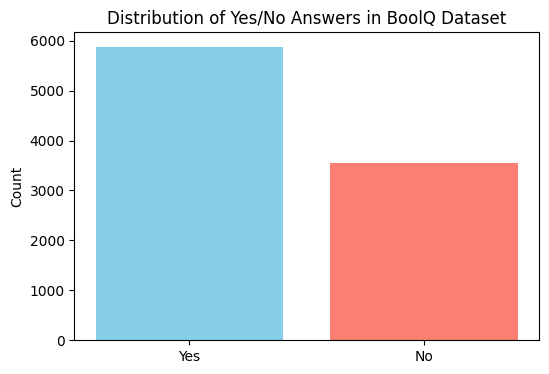

In [ ]:
# Count Yes and No answers in the training set
yes_count = sum(1 for x in dataset['train'] if x['answer'] is True)
no_count = len(dataset['train']) - yes_count

print("Number of 'Yes' answers:", yes_count)
print("Number of 'No' answers:", no_count)

# Plot the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(["Yes", "No"], [yes_count, no_count], color=['skyblue', 'salmon'])
plt.ylabel("Count")
plt.title("Distribution of Yes/No Answers in BoolQ Dataset")
plt.show()


Average question length: 43.99193805028111
Max question length: 100


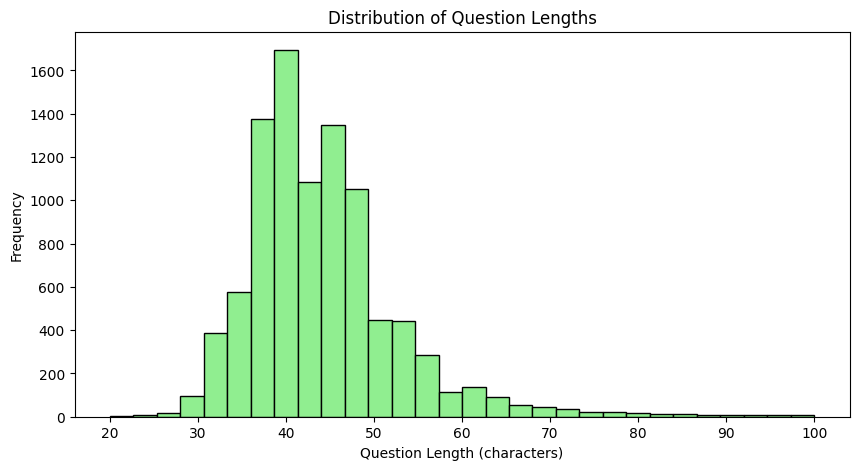

In [ ]:
# Calculate question lengths (in characters)
question_lengths = [len(sample['question']) for sample in dataset['train']]

# Display average and max question length
print("Average question length:", sum(question_lengths) / len(question_lengths))
print("Max question length:", max(question_lengths))

# Plot the distribution of question lengths
plt.figure(figsize=(10, 5))
plt.hist(question_lengths, bins=30, color='lightgreen', edgecolor='black')
plt.xlabel("Question Length (characters)")
plt.ylabel("Frequency")
plt.title("Distribution of Question Lengths")
plt.show()


##Modeling

###Initialize the Tokenizer and Model

We’re using distilbert-base-uncased as our model checkpoint, which is efficient for binary classification tasks.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)  # num_labels=2 for "Yes"/"No" classes


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


###Convert Labels and Preprocess Data
Since "Yes" and "No" are in text format, we’ll convert them to 1 (Yes) and 0 (No). Then, we’ll tokenize the question and passage fields.

In [ ]:
# Convert "Yes"/"No" answers to binary labels and tokenize
def preprocess_function(examples):
    examples['labels'] = [1 if answer else 0 for answer in examples['answer']]  # 1 for "Yes", 0 for "No"
    inputs = tokenizer(examples['question'], examples['passage'], truncation=True, padding="max_length", max_length=128)
    inputs["labels"] = examples["labels"]
    return inputs

train_dataset = dataset['train'].map(preprocess_function, batched=True)
val_dataset = dataset['validation'].map(preprocess_function, batched=True)

# Set format for PyTorch
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/9427 [00:00<?, ? examples/s]

Map:   0%|          | 0/3270 [00:00<?, ? examples/s]

###Handling Class Imbalance
Given the imbalance between "Yes" and "No" samples, we’ll apply class weights in the loss function to penalize the majority class more heavily.

In [ ]:
from transformers import Trainer
import torch

class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").to(model.device)  # Ensure labels are on the same device as the model
        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits
        # Move class weights to the correct device
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss



###Set Training Arguments and Initialize Trainer
Configure training arguments with remove_unused_columns=False to avoid removing any necessary columns during training.

In [ ]:
# Calculate class weights for imbalance handling
yes_weight = len(train_dataset) / (2 * yes_count)
no_weight = len(train_dataset) / (2 * no_count)
class_weights = torch.tensor([no_weight, yes_weight])

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    remove_unused_columns=False
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Initialize the custom trainer with class weights
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    class_weights=class_weights
)

###Training the Model


In [ ]:
# Start the fine-tuning process
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.636200,0.610950
2,0.523100,0.623561


TrainOutput(global_step=2358, training_loss=0.5897879822968021, metrics={'train_runtime': 314.0199, 'train_samples_per_second': 60.041, 'train_steps_per_second': 7.509, 'total_flos': 624385083565056.0, 'train_loss': 0.5897879822968021, 'epoch': 2.0})

##Evaluation

###Evaluation with Default Metrics
First, let’s use trainer.evaluate() to get a quick look at the validation loss.

In [ ]:
# Evaluate model performance on the validation set
eval_results = trainer.evaluate()
print(f"Validation Loss: {eval_results['eval_loss']:.4f}")


Validation Loss: 0.6236


###Additional Evaluation Metrics: Accuracy, F1 Score, Precision, Recall, and Confusion Matrix

Validation Accuracy: 0.6890
Validation F1 Score: 0.7427
Validation Precision: 0.7646
Validation Recall: 0.7221


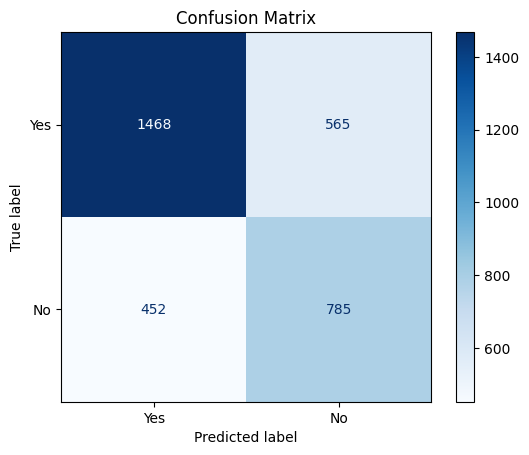

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get model predictions on the validation set
predictions = trainer.predict(val_dataset)

# Extract predicted labels and true labels
preds = np.argmax(predictions.predictions, axis=1)  # Get the class with the highest score (Yes/No)
labels = predictions.label_ids  # True labels

# Calculate additional metrics
accuracy = accuracy_score(labels, preds)
f1 = f1_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation F1 Score: {f1:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")

# Plot Confusion Matrix
cm = confusion_matrix(labels, preds, labels=[1, 0])  # [1, 0] maps to Yes and No
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Yes", "No"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


##Testing

###Testing Function

In [ ]:
def test_qa(question, passage, threshold=0.75):
    # Move inputs to the model's device (e.g., GPU if available)
    device = model.device
    inputs = tokenizer(question, passage, return_tensors="pt").to(device)

    # Perform inference
    outputs = model(**inputs)
    logits = outputs.logits
    # Get the predicted class (0 for "No", 1 for "Yes")
    prediction = logits.softmax(dim=-1).argmax().item()
    return "Yes" if prediction == 1 else "No"


###Sample Questions and Passages for Testing
Here’s a list of question-passage pairs, some expected to return "Yes" and others "No," to check the model’s accuracy.

In [ ]:
# List of question-passage pairs for testing
qa_pairs = [
    # Expected "Yes" answers
    {
        "question": "Is the Eiffel Tower located in Paris?",
        "passage": "The Eiffel Tower is one of the most iconic structures in the world, located in Paris, France."
    },
    {
        "question": "Do whales breathe air?",
        "passage": "Whales are mammals, which means they must come to the surface to breathe air through their blowholes."
    },
    # Expected "No" answers
    {
        "question": "Is the Eiffel Tower in New York?",
        "passage": "The Eiffel Tower is a famous structure located in Paris, France, not in New York."
    },
    {
        "question": "Can humans breathe underwater without equipment?",
        "passage": "Humans cannot breathe underwater without special equipment like scuba gear, as we lack gills to extract oxygen from water."
    }
]


In [ ]:

# Run the testing function on each pair
def test_qa_model(qa_pairs):
    for i, pair in enumerate(qa_pairs):
        question = pair["question"]
        passage = pair["passage"]

        # Get the model's answer
        answer = test_qa(question, passage)

        # Print the results
        print(f"Test {i+1}")
        print("Question:", question)
        print("Predicted Answer:", answer)
        print("-" * 50)

In [ ]:

# Execute the test
test_qa_model(qa_pairs)

Test 1
Question: Is the Eiffel Tower located in Paris?
Predicted Answer: Yes
--------------------------------------------------
Test 2
Question: Do whales breathe air?
Predicted Answer: Yes
--------------------------------------------------
Test 3
Question: Is the Eiffel Tower in New York?
Predicted Answer: No
--------------------------------------------------
Test 4
Question: Can humans breathe underwater without equipment?
Predicted Answer: No
--------------------------------------------------
